In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import ndimage
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from IPython.display import clear_output

import keras
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  
from keras.utils.np_utils import to_categorical  

from constants import img_size, train_data_dir, dev_data_dir, epochs, batch_size, num_class

Using TensorFlow backend.


## Callbacks

In [2]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False)
        self.ax1 = ax1
        self.ax2 = ax2
    
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('categorical_accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_categorical_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        self.ax1.plot(self.x, self.losses, label="loss")
        self.ax1.plot(self.x, self.val_losses, label="val loss")
        self.ax1.legend()
        self.ax2.plot(self.x, self.acc, label="accuracy")
        self.ax2.plot(self.x, self.val_acc, label="val accuracy")
        self.ax2.legend()
        plt.show()
        
        for i in range(self.i):
            print('Epoch ' + str(i+1))
            print('-----------------------')
            print('- Loss:', self.losses[i])
            print('- Accuracy:', self.acc[i])
            print('- Validation loss:', self.val_losses[i])
            print('- Validation accuracy:', self.val_acc[i])
            print(' ')
            
checkpoint = keras.callbacks.ModelCheckpoint(
    './model_2/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=False, 
    save_weights_only=True, 
    mode='auto', 
    period=1,
)

## Model

In [3]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))

X = base_model.output
X = Flatten()(X)
X = Dense(2048, activation='relu')(X)
#X = Dropout(0.2)(X)
X = Dense(1024, activation='relu')(X)
#X = Dropout(0.2)(X)
outputs = Dense(num_class, activation='softmax')(X)

model = Model(inputs=base_model.inputs, outputs=outputs)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 112, 112, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 112, 112, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 56, 56, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 28, 28, 128)       0         
__________

## Generator

In [4]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[1., 1.2],
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    rescale=1./255,
)

dev_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    seed=0,
)

dev_generator = train_datagen.flow_from_directory(
    dev_data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    seed=0,
)

Found 9144 images belonging to 120 classes.
Found 1078 images belonging to 120 classes.


## Training

In [6]:
plot_losses = PlotLosses()

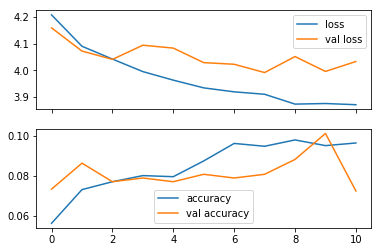

Epoch 1
-----------------------
- Loss: 4.20812504686
- Accuracy: 0.0562117235346
- Validation loss: 4.15945699883
- Validation accuracy: 0.0732838589981
 
Epoch 2
-----------------------
- Loss: 4.09051526625
- Accuracy: 0.073053368329
- Validation loss: 4.07246943706
- Validation accuracy: 0.0862708719852
 
Epoch 3
-----------------------
- Loss: 4.04259347206
- Accuracy: 0.076990376203
- Validation loss: 4.04136228031
- Validation accuracy: 0.0769944341373
 
Epoch 4
-----------------------
- Loss: 3.99562943868
- Accuracy: 0.0800524934383
- Validation loss: 4.09445510326
- Validation accuracy: 0.0788497217345
 
Epoch 5
-----------------------
- Loss: 3.96361953276
- Accuracy: 0.0795056867892
- Validation loss: 4.08364145212
- Validation accuracy: 0.0769944341373
 
Epoch 6
-----------------------
- Loss: 3.93472171289
- Accuracy: 0.0873797025372
- Validation loss: 4.0292251318
- Validation accuracy: 0.0807050092764
 
Epoch 7
-----------------------
- Loss: 3.91988135865
- Accuracy: 0

KeyboardInterrupt: 

In [8]:
model.load_weights('./model_2/weights.02-4.28.hdf5')

model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=dev_generator,
    validation_steps=len(dev_generator),
    callbacks=[plot_losses, checkpoint], 
)